In [1]:
#Adapted from https://pyimagesearch.com/2022/02/21/u-net-image-segmentation-in-keras/
#Try a larger dataset for better performace.
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
#Download sample dataset
dataset, info = tfds.load('oxford_iiit_pet:4.*.*', with_info=True)

In [3]:
#Data pre-processing
def resize(input_image, input_mask):
   input_image = tf.image.resize(input_image, (128, 128), method="nearest")
   input_mask = tf.image.resize(input_mask, (128, 128), method="nearest")
   return input_image, input_mask

def augment(input_image, input_mask):
   if tf.random.uniform(()) > 0.5:
       # Random flipping of the image and mask
       input_image = tf.image.flip_left_right(input_image)
       input_mask = tf.image.flip_left_right(input_mask)

   return input_image, input_mask

def normalize(input_image, input_mask):
   input_image = tf.cast(input_image, tf.float32) / 255.0
   input_mask -= 1
   return input_image, input_mask

In [4]:
#Dataloaders
def load_image_train(datapoint):
   input_image = datapoint["image"]
   input_mask = datapoint["segmentation_mask"]
   input_image, input_mask = resize(input_image, input_mask)
   input_image, input_mask = augment(input_image, input_mask)
   input_image, input_mask = normalize(input_image, input_mask)

   return input_image, input_mask

def load_image_test(datapoint):
   input_image = datapoint["image"]
   input_mask = datapoint["segmentation_mask"]
   input_image, input_mask = resize(input_image, input_mask)
   input_image, input_mask = normalize(input_image, input_mask)

   return input_image, input_mask

In [5]:
train_dataset = dataset["train"].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = dataset["test"].map(load_image_test, num_parallel_calls=tf.data.AUTOTUNE)

In [6]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
train_batches = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_batches = test_dataset.take(3000).batch(BATCH_SIZE)
test_batches = test_dataset.skip(3000).take(669).batch(BATCH_SIZE)

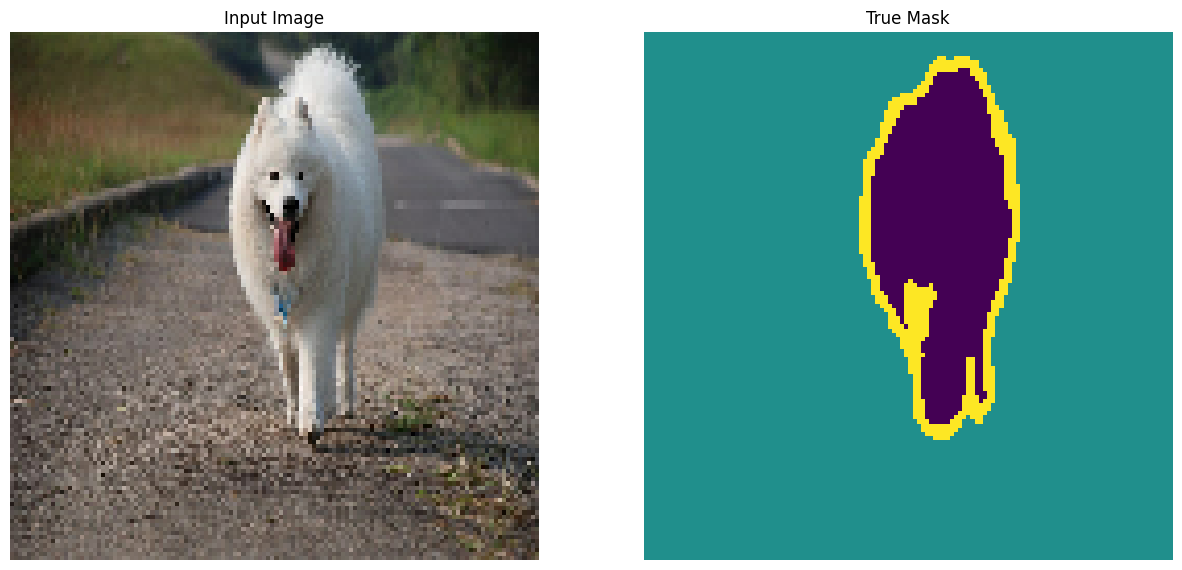

In [7]:
def display(display_list):
 plt.figure(figsize=(15, 15))

 title = ["Input Image", "True Mask", "Predicted Mask"]

 for i in range(len(display_list)):
   plt.subplot(1, len(display_list), i+1)
   plt.title(title[i])
   plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
   plt.axis("off")
 plt.show()

sample_batch = next(iter(train_batches))
random_index = np.random.choice(sample_batch[0].shape[0])
sample_image, sample_mask = sample_batch[0][random_index], sample_batch[1][random_index]
display([sample_image, sample_mask])

In [8]:
#Define architecture here

# Positional Embedding Function
def get_positional_embeddings(seq_len, d_model):
    pos = tf.range(seq_len, dtype=tf.float32)[:, tf.newaxis]
    i = tf.range(d_model, dtype=tf.float32)[tf.newaxis, :]
    angle_rates = 1 / tf.pow(10000.0, (2 * (i // 2)) / d_model)
    angle_rads = pos * angle_rates
    sines = tf.math.sin(angle_rads[:, 0::2])
    cosines = tf.math.cos(angle_rads[:, 1::2])
    pos_encoding = tf.concat([sines, cosines], axis=-1)
    return tf.expand_dims(pos_encoding, axis=0)  # shape: (1, seq_len, d_model)

# Transformer Block
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = models.Sequential([
            layers.Dense(ff_dim, activation='gelu'),
            layers.Dense(embed_dim),
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training=None):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# ViT-U-Net Model
def small_vit_unet_segmentation_model(
    input_shape=(128, 128, 3),
    patch_size=16,
    num_classes=3,
    projection_dim=64,
    transformer_layers=2,
    num_heads=2,
    ff_dim=128,
):
    inputs = layers.Input(shape=input_shape)
    patch_h = patch_w = patch_size
    patch_grid_size = input_shape[0] // patch_size
    num_patches = patch_grid_size ** 2

    # Patch extraction
    def extract_patches_fn(x):
        patches = tf.image.extract_patches(
            images=x,
            sizes=[1, patch_h, patch_w, 1],
            strides=[1, patch_h, patch_w, 1],
            rates=[1, 1, 1, 1],
            padding='VALID'
        )
        return tf.reshape(patches, [tf.shape(x)[0], -1, patch_h * patch_w * input_shape[2]])

    patches = layers.Lambda(extract_patches_fn)(inputs)
    x = layers.Dense(projection_dim)(patches)

    # Add positional encoding
    pos_encoding = get_positional_embeddings(num_patches, projection_dim)
    x = x + pos_encoding[:, :num_patches, :]

    # Transformer blocks
    for _ in range(transformer_layers):
        x = TransformerBlock(projection_dim, num_heads, ff_dim)(x)

    # Bottleneck
    x = layers.Reshape((patch_grid_size, patch_grid_size, projection_dim))(x)

    # Decoder: upscale back to 128x128
    x = layers.Conv2DTranspose(128, 3, strides=2, padding="same", activation="relu")(x)  # 8 → 16
    x = layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu")(x)   # 16 → 32
    x = layers.Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu")(x)   # 32 → 64
    x = layers.Conv2DTranspose(16, 3, strides=2, padding="same", activation="relu")(x)   # 64 → 128


    outputs = layers.Conv2D(num_classes, 1, activation="softmax", padding="same")(x)

    return tf.keras.Model(inputs=inputs, outputs=outputs, name="SmallViT-U-Net")

In [9]:
# Define the model
unet_model = small_vit_unet_segmentation_model(input_shape=(128, 128, 3))

In [10]:
unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="sparse_categorical_crossentropy",
                  metrics=['accuracy'])

In [11]:
#Training loop

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',       # Metric to monitor
    patience=10,              # Stop after 10 epochs without improvement
    restore_best_weights=True # Restore model weights from the epoch with the best value of the monitored quantity
)

# Define training parameters
NUM_EPOCHS = 100  # More epochs, but early stopping will likely halt before reaching this
TRAIN_LENGTH = info.splits["train"].num_examples
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
VAL_SUBSPLITS = 5
TEST_LENTH = info.splits["test"].num_examples
VALIDATION_STEPS = TEST_LENTH // BATCH_SIZE // VAL_SUBSPLITS

# Start training with early stopping
model_history = unet_model.fit(
    train_batches,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    verbose=1,
    validation_data=test_batches,
    callbacks=[early_stopping]
)

Epoch 1/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 41s 346ms/step - accuracy: 0.5218 - loss: 1.0188 - val_accuracy: 0.5897 - val_loss: 0.8073
Epoch 2/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 203ms/step - accuracy: 0.6612 - loss: 0.7750 - val_accuracy: 0.7222 - val_loss: 0.7006
Epoch 3/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 202ms/step - accuracy: 0.7275 - loss: 0.6888 - val_accuracy: 0.7409 - val_loss: 0.6570
Epoch 4/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 200ms/step - accuracy: 0.7412 - loss: 0.6572 - val_accuracy: 0.7390 - val_loss: 0.6486
Epoch 5/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 186ms/step - accuracy: 0.7527 - loss: 0.6289 - val_accuracy: 0.7535 - val_loss: 0.6135
Epoch 6/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 185ms/step - accuracy: 0.7598 - loss: 0.6051 - val_accuracy: 0.7571 - val_loss: 0.6048
Epoch 7/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 12s 217ms/step - accuracy: 0.7637 - loss: 0.5966 - val_accuracy: 0.7707 - val_loss: 0.5739
Epoch 8/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 198ms/step - accuracy: 0.7705 - loss: 0.5765 - 

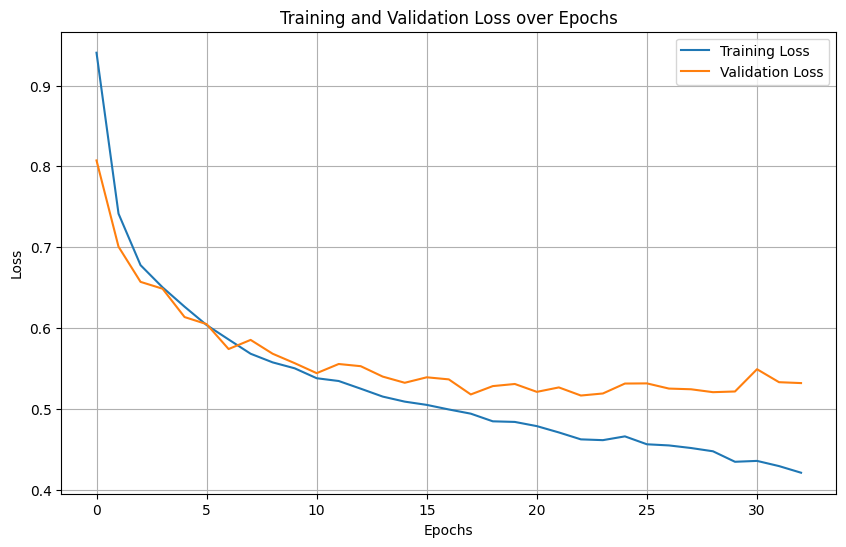

In [14]:
#Extract last epoch

# Get the history dictionary
history = model_history.history

# Get the total number of completed epochs
last_epoch = len(history['loss'])

#Plot losses

# Extract loss values
train_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
epochs_range = range(last_epoch)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet_model.predict(image)
            display_images(image[0], mask[0], create_mask(pred_mask))
    else:
        pred = model.predict(sample_image[tf.newaxis, ...])
        display_images(sample_image, sample_mask, create_mask(pred))

def display_images(image, mask, pred_mask):
    plt.figure(figsize=(15, 5))

    title = ['Input Image', 'True Mask', 'Predicted Mask']
    images = [image, mask, pred_mask]

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        if images[i].shape[-1] == 1:
            plt.imshow(tf.squeeze(images[i]), cmap='gray')
        else:
            plt.imshow(images[i])
        plt.axis('off')

    plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


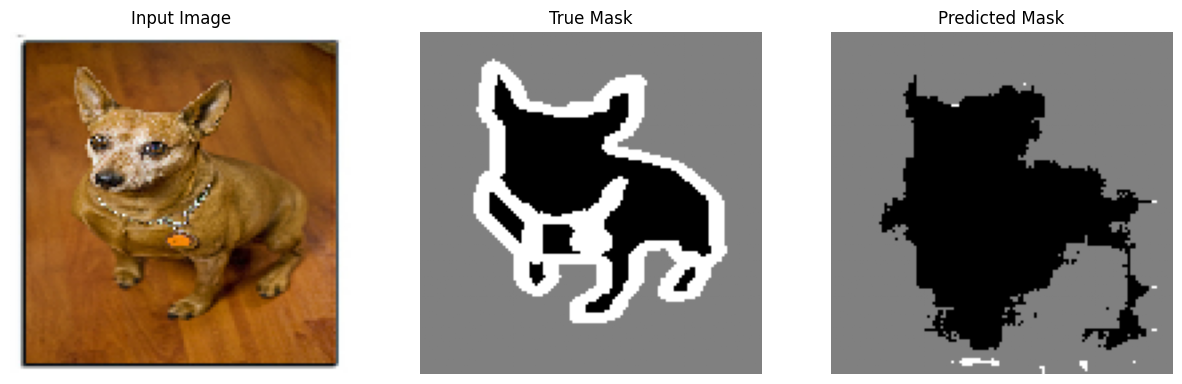

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


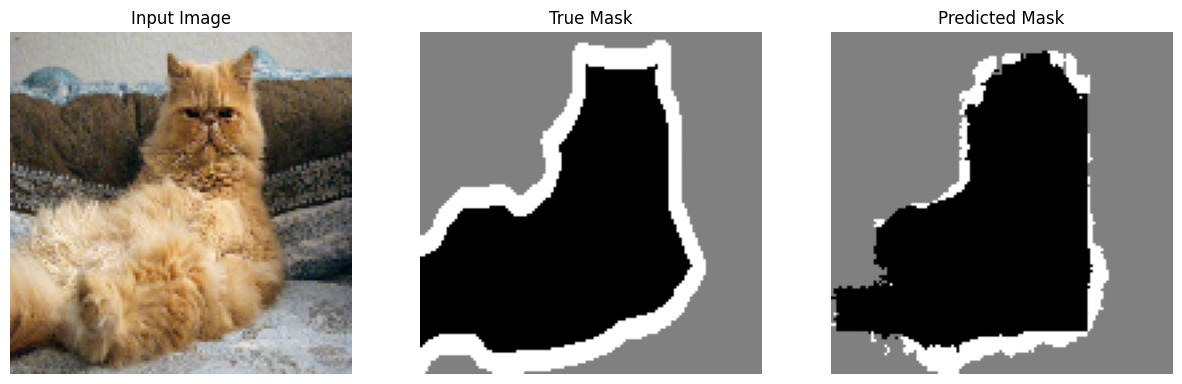

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


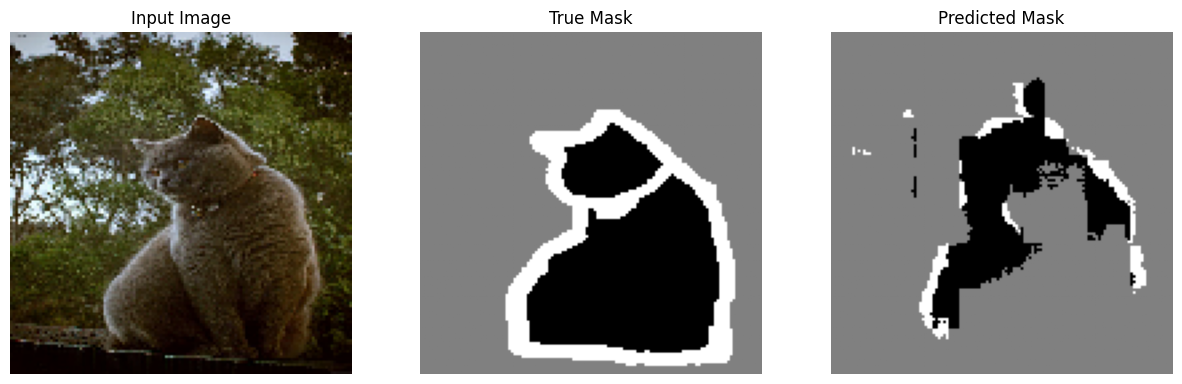

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


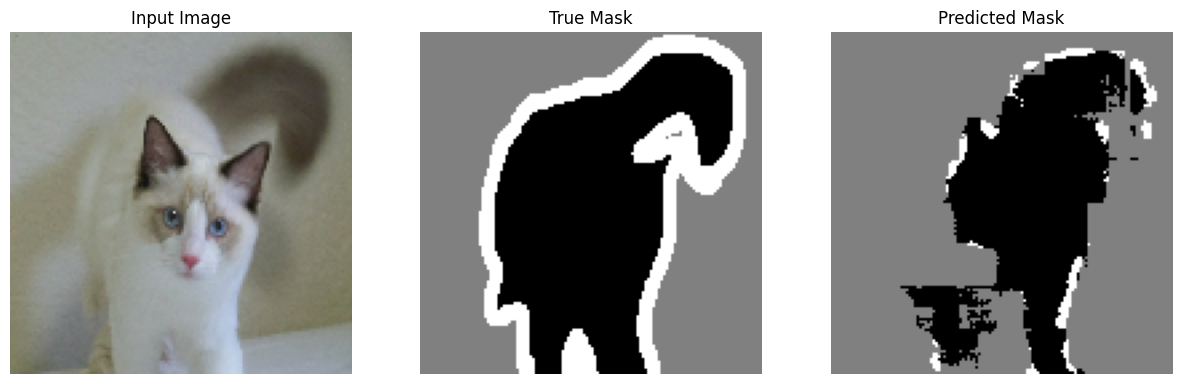

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


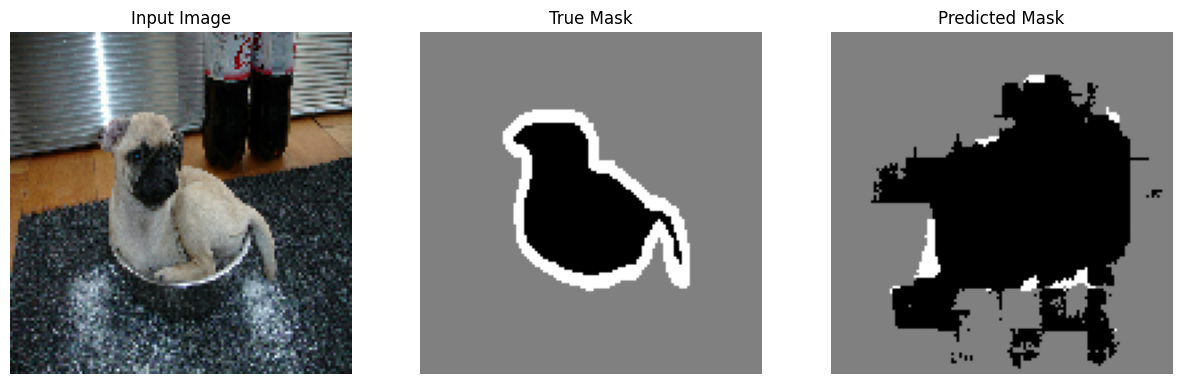

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


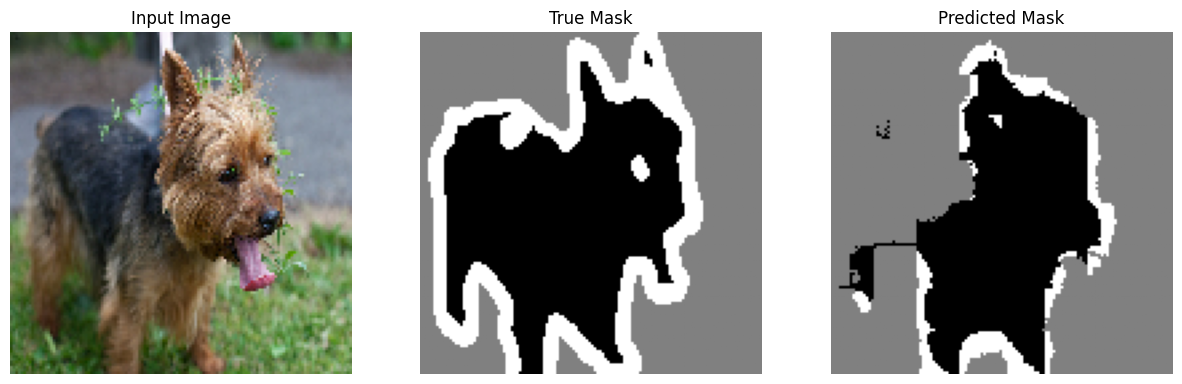

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


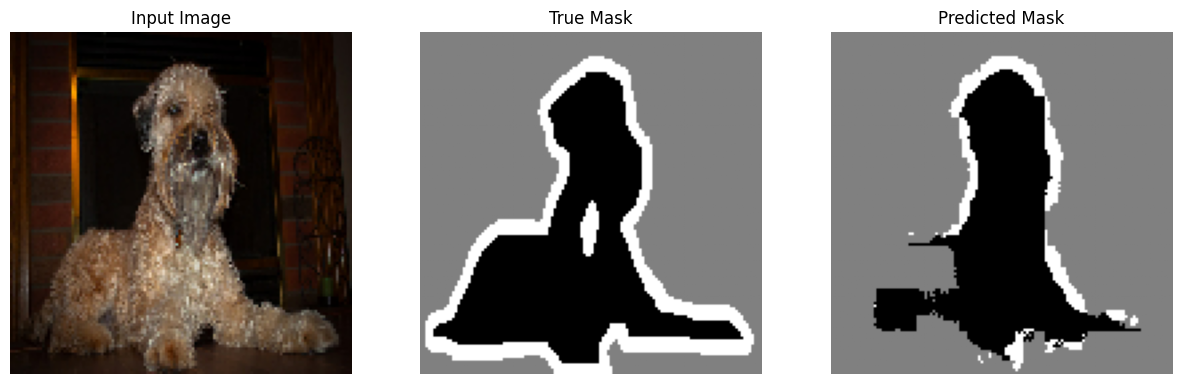

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


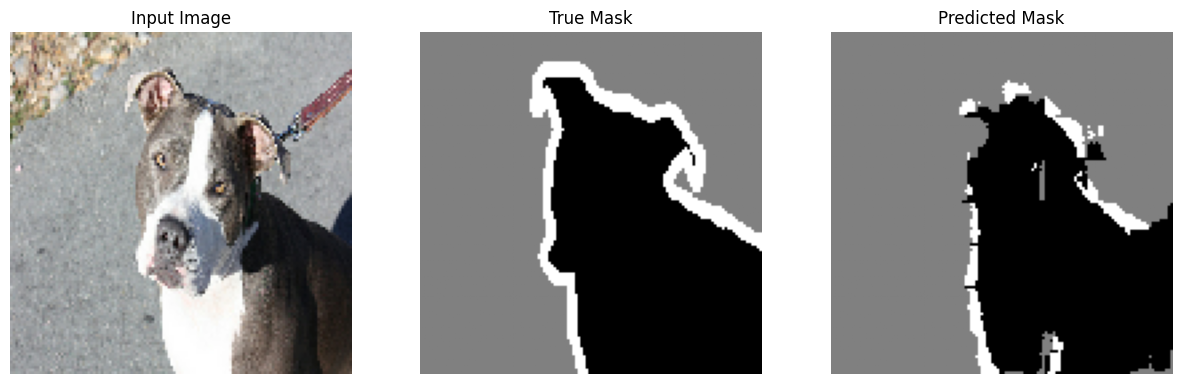

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


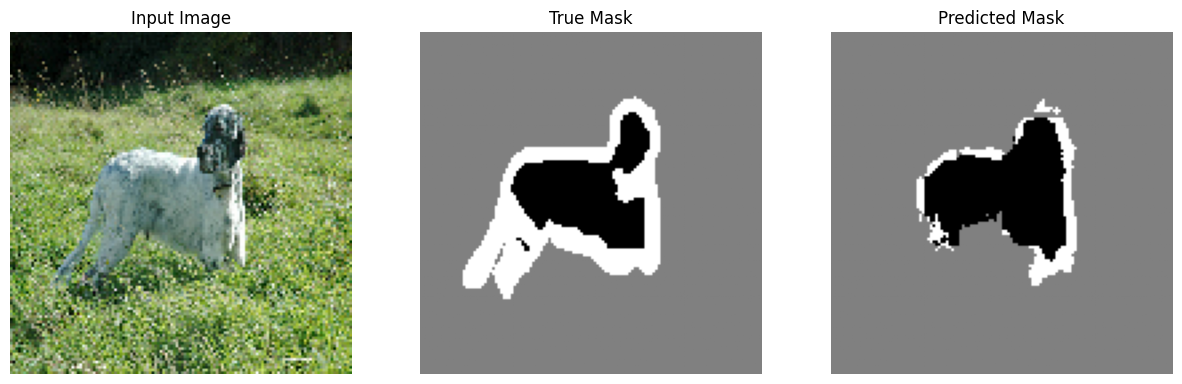

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


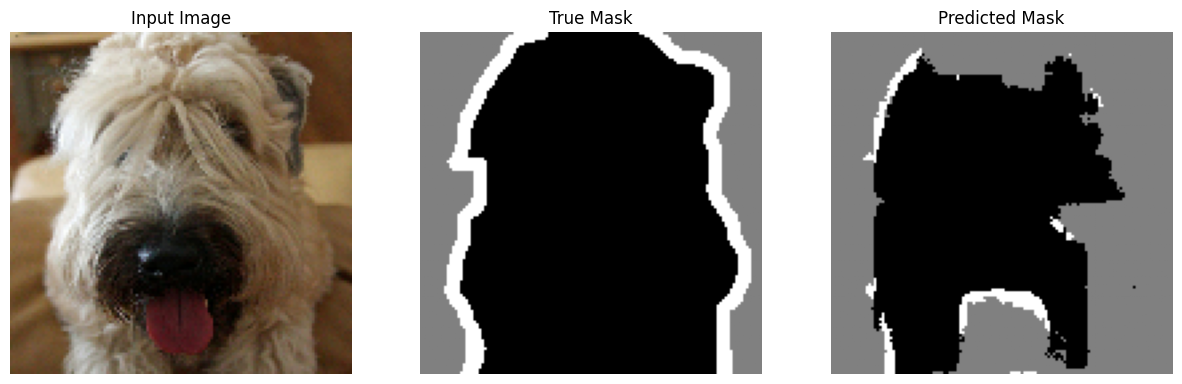

In [16]:
show_predictions(dataset=test_batches, num=10)